# 차원 축소

## 8.1 차원의 저주

- 차원이 커질수록 데이터셋이 매우 희박해짐(임의의 두 점 사이의 평균 거리가 매우 작아짐)  
- 대부분의 훈련 데이터가 서로 멀리 떨어져 있으며, 새로운 샘플도 훈련 샘플과 멀리 떨어질 가능성이 높음  
- 차원이 클수록 과대적합의 위험이 커짐  

## 8.2 차원 축소를 위한 접근 방법

### 8.2.1 투영

- 대부분의 실전문제는 훈련 샘플이 모든 차원에 균일하게 퍼져 있지 않음  
- 서로 강하게 연관되어 있는 특성이 존재  
- 모든 훈련 샘플이 사실 고차원 공간 안의 저차원 부분공간 가까이 놓여 있음  

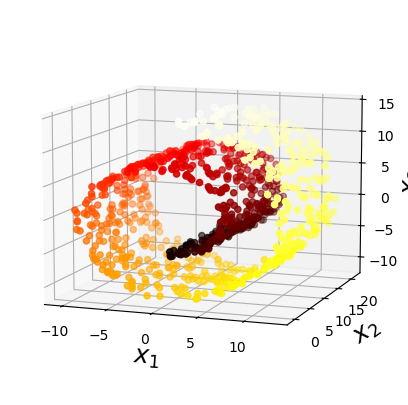

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.datasets import make_swiss_roll


X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

그러나 스위스 롤 같이 데이터셋처럼 부분 공간이 뒤틀려있거나 휘어 있는 형태는 투영이 최선의 방법이 아님 (대신 매니폴드 사용)  

### 8.2.2 매니폴드 학습

- 매니폴드 가정(가설): 대부분 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여있음  
- 이러한 가정이 항상 유효하지는 않으며 전적으로 데이터 셋에 달려있음  

## 8.3 PCA

주성분 분석(PCA): 가장 가까운 초평면을 정의한 다음, 데이터를 이 평면에 투영  

### 8.3.1 분산 보존

분산을 최대한 보존하는 초평면을 찾아 투영 (정보 손실 최소화)  
= 원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화  

### 8.3.2 주성분

#### 특이값 분해
- 훈련 세트 행렬 X를 세 개의 행렬의 점곱인 $U \cdot \sum \cdot V^T$로 분해  
- 찾고자 하는 모든 주성분이 $V$에 담겨 있음  

In [3]:
import numpy as np

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

c1 = Vt.T[:,0]
c2 = Vt.T[:,1]

print(c1,c2)

[0.56791312 0.15670748 0.80803308] [-0.77712377 -0.2213858   0.5891239 ]


### 8.3.3 d차원으로 투영하기

$ X_{d-proj} = X \cdot W_d $

In [4]:
# 첫 두 개의 주성분으로 정의된 평면에 훈련 세트를 투영
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

X2D[:5]

array([[  2.08374001,   9.97769318],
       [ 12.53136592,   4.15352368],
       [ -4.26069341, -11.17296129],
       [-10.69166733,   0.25780371],
       [  2.84006484,  -5.02094523]])

### 8.3.4 사이킷런 사용하기

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

### 8.3.5 설명된 분산의 비율

In [6]:
# 변수에 저장된 주성분의 설명된 분산의 비율
pca.explained_variance_ratio_

array([0.40782396, 0.3020019 ])

첫 번째 축에 분산의 84.2%, 두 번째 축에 분산의 14.6%가 놓여있음  

### 8.3.6 적절한 차원 수 선택하기

In [7]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

In [9]:
# n_components가 0~1 사이면 보존하려는 분산의 비율을 나타내고, 1보다 큰 정수는 주성분의 수를 지정한다.
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

차원 수에 대한 함수로 나타낸 설명된 분산  

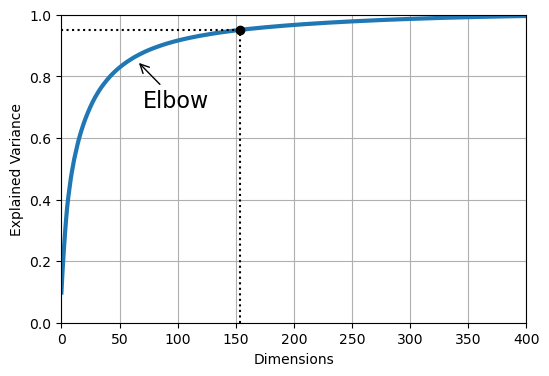

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate(
    "Elbow",
    xy=(65, 0.85),
    xytext=(70, 0.7),
    arrowprops=dict(arrowstyle="->"),
    fontsize=16,
)
plt.grid(True)
plt.show()

### 8.3.7 압축을 위한 PCA

재구성 오차: 원본 데이터와 압축 후 원보간 데이터 사이의 평균 제곱 거리  

In [11]:
pca = PCA(n_components= 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [12]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate(
        [instances, np.zeros((n_empty, size * size))], axis=0
    )

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다.
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(
        n_rows * size, images_per_row * size
    )
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

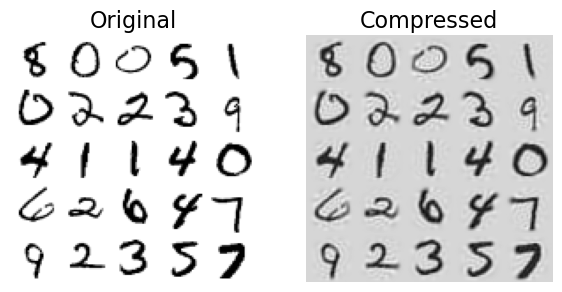

In [13]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

### 8.3.8 점진적 PCA

- PCA 구현의 문제: SVD 알고리즘을 실행하기 위해 전체 훈련 세트를 메모리에 올려야함  
- 점진적 PCA(IPCA): 훈련 세트를 미니배치로 나눈 뒤 IPCA 알고리즘에 한번에 하나씩 주입  
  (훈련 세트가 클 때, 온라인으로 PCA 적용 시 유용)  

In [14]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [17]:
# memmap() 구조를 만들고 MNIST 데이터를 복사하여 파일로 저장
m, n = X_train.shape
my_mnist = "my_mnist.data"
X_mm = np.memmap(my_mnist, dtype="float32", mode="write", shape=(m, n))
X_mm[:] = X_train
del X_mm

In [18]:
# memmap: 하드 디스크의 이진 파일에 저장된 매우 큰 배열을 메모리에 들어있는 것처럼 다루는 것으로 메모리 부족 문제를 해결
X_mm = np.memmap(filename=my_mnist, dtype="float32", mode="readonly", shape=(m, n))
batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

### 8.3.9 랜덤 PCA

- 확률적 알고리즘으로, 첫 d개의 주성분에 대한 근사값을 빠르게 찾음  
- 시간 복잡도는  $O(m \times n^2)+O(n^3)$ -> $O(m \times d^2)+O(d^3)$로 d가 n보다 작을수록 빨라짐  

In [ ]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

## 8.4 커널 PCA

서포트 벡터 머신의 커널 트릭처럼 PCA에서 복잡한 비선형 투영으로의 차원 축소  

In [ ]:
# 코드 실행시 메모리 초과 문제 발생

from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=1, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

### 8.4.1 커널 선택과 하이퍼파라미터 튜닝

In [ ]:
# 코드 실행시 메모리 초과 문제 발생

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10), 
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X,y)

print(grid_search.best_params)

- 커널 트릭 덕분에 훈련 세트를 특성 맵을 사용한 무한 차원의 특성 공간에 매핑한 다음, 변화된 데이터셋을 선형 PCA를 사용해 2D로 투영한 것과 수학적으로 동일  
- 축소된 공간에 있는 샘플에 대해 선형 PCA를 역전시키면 재구성된 데이터 포인트는 원본 공간이 아닌 특성 공간에 놓이게 됨  
- 이 특성 공간은 무한 차원이기 때문에 재구성된 포인트를 계산할 수 없고 재구성에 따른 실제 에러를 계산할 수 없음  
- **재구성 원상**: 재구성된 포인트에 가깝게 매핑된 원본 공간의 포인트를 찾을 수 있음. 이를 통해 원본 샘플과의 제곱 거리를 축정할 수 있다.  

In [ ]:
# 코드 실행시 메모리 초과 문제 발생

# 투영된 샘플을 훈련 세트로, 원본 샘플을 타깃으로 하는 지도 학습 회귀 모델 훈련 (fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel = "rbf", gamma=0.0433,fit_inverse_transform=True)
X_reduced = rbf_pca.fit_trainsform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

## 8.5 LLE

지역 선형 임베딩(LLE)  
- 비선형 차원 축소(NLDR) 기술  
- 투영에 의존하지 않는 매니폴드 학습  
- 각 훈련 샘플이 가장 가까운 이웃에 얼마나 선형적으로 연관되어 있는지 측정  
- 국부적인 관계가 가장 잘 보존되는 훈련세트의 저차원 표현을 찾음  
- 잡음이 너무 많지 않은 경우 꼬인 매니폴드를 펼치는데 잘 작동  

In [19]:
# 실행 시간 매우 오래 걸림
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

#### 작동 방식 - 1단계
1. 각 훈련샘플 $x^{(i)}$에 대해 가장 자까운 $k$개의 샘플을 찾는다.  
2. 이 이웃에 대한 선형 함수로 $x^{(i)}$를 재구성한다. ($x^{(i)}$와 $\sum^m_{j=1} w_{i,j}x^{(j)}$ 사이의 제곱 거리가 최소가 되는 w_{i,j}를 찾는다.)  
3. $x^{(j)}$가 $x^{(i)}$의 가장 가까운 k개 이웃 중 하나가 아닐 경우 w_{i,j} = 0이 된다.  
4. 제한이 있는 최적화 문제가 된다.  
$$\hat{W} = argmin_w \sum^{m}_{i=1} \left(x^{(i)} - \sum^m_{j=1} w_{i,j}x^{(j)} \right)^2$$  
- 조건  
    - $w_{i,j} = 0$ ($x^{(j)}$가 $x^{(i)}$의 가장 가까운 k개 이웃 중 하나가 아닐 때)  
    - $\sum^m_{j=1} w_{i,j} = 1$ (i=1,2,...,m일 때)     

#### 작동 방식 - 2단계
1단계를 거친 가중치 행렬 $\hat{W}$은 훈련 샘플 사이에 있는 지역 선형 관계를 담고있다.
1. 이 관계가 최대한 보존되도록 훈련 샘플을 d차원 공간으로 매핑한다.  
2.  만약 $z^{(i)}$가 d차원 공간에서 $x{(i)}$의 상(image)이라면 가능한 한 $z^{(i)}$와  $\sum^m_{j=1} \hat{w}_{i,j}z^{(j)}$ 사이의 거리가 최소화되어야 한다.  
3. 이는 제약이 없는 최적화 문제로 바꾸어 준다.  
$$Z = argmin_z \sum^{m}_{i=1} \left(z^{(i)} - \sum^m_{j=1} \hat{w}_{i,j}z^{(j)}\right)^2$$  

**샘플을 고정하고 최적의 가중치를 찾는 대신, 가중치를 고정하고 저차원의 공간에서 샘플 이미지의 최적 위치를 찾는다.**  
- 계산 복잡도  
    - k개의 가장 가까운 이웃 찾기 $O(mlog(m)nlog(k))$  
    - 가중치 최적화 $O(mnk^3)$  
    - 저차원 표현 만들기 $O(dm^2)$  
- 마지막 항의 $m^2$ 때문에 대량의 데이터셋에 적용하기 어려운 알고리즘  

## 8.6 다른 차원 축소 기법

#### 다차원 스케일링(MDS)  
- 샘플 간의 거리를 보존하면서 차원을 축소  
#### Isomap  
- 각 샘플을 가장 가까운 이웃과 연결하는 식으로 그래프를 만들고, 샘플 간 지오데식 거리를 유지하면서 차원을 축소  
#### t-SNE  
- 비슷한 샘플은 가까이, 비슷하지 않은 샘플은 멀리 떨어지도록 차원을 축소  
- 고차원 공간에 있는 샘플의 군집을 시각화 하는 등의 시각화에 많이 사용  
#### 선형 판별 분석(LDA)  
- 분류 알고리즘으로 훈련 과정에서 클래스 사이를 가장 잘 구분하는 축을 학습  
- 이 축을 투영되는 초평면을 정의하는데 사용  
- 투영을 통해 가능한 한 클래스를 멀리 떨어지게 유지시킴  
- SVM 분류기 같은 다른 분류 알고리즘을 적용하기 전에 차원을 축소시키는 데 좋음  

## 8.7 연습문제

1. 데이터셋의 차원을 축소하는 주요 목적은 무엇인가요? 대표적인 단점은 무엇인가요?

2. 차원의 저주란 무엇인가요?

3. 데이터셋의 차원을 축소시키고 나서 이 작업을 원복할 수 있나요? 할 수 있다면 어떻게 가능할까요? 가능하지 않다면 왜일까요?

4. 매우 비선형적인 데이터셋의 차원을 축소하는 데 PCA를 사용할 수 있을까요?

5. 설명된 분산을 95%로 지정한 PCA를 1,000개의 차원을 가진 데이터셋에 적용한다고 가정하겠습니다. 결과 데이터셋의 차원은 얼마나 될까요?

6. 기본 PCA, 점진적 PCA. 랜덤 PCA, 커널 PCA는 어느 경우에 사용될까요?

7. 어떤 데이터셋에 적용한 차원 축소 알고리즘의 성능을 어떻게 평가할 수 있을까요?

8. 두 개의 차원 축소 알고리즘을 연결할 수 있을까요?

9. (3장에서 소개한) MINIST 데이터셋을 로드하고 훈련 세트와 테스트 세트로 분할합니다 (처음 60,000개는 훈련을 위한 샘플이고 나머지 10,000개는 테스트용입니다). 이 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 시간을 잰 다음, 테스트 세트로 만들어진 모델을 평가합니다. 그런 다음 PCA를 사용해 설명된 분산이 95%가 되도록 차원을 축소합니다. 이 축소된 데이터셋에 새로운 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 확인합니다. 훈련 속도가 더 빨라졌나요? 이제 테스트 세트에서 이 분류기를 평가해보세요. 이전 분류기와 비교해서 어떤가요?

10. t-SNE 알고리즘을 사용해 MNIST 데이터셋을 2차원으로 축소시키고 맷플롯립으로 그래 프를 그려보세요. 이미지의 타깃 클래스마다 10가지 색깔로 나타낸 산점도를 그릴 수 있습 니다. 또는 샘플의 위치에 각기 다른 색깔의 숫자를 나타낼 수도 있고, 숫자 이미지 자체의 크기를 줄여서 그릴 수도 있습니다 (모든 숫자를 다 그리면 그래프가 너무 복잡해지므로 무 작위로 선택한 샘플만 그리거나, 인접한 곳에 다른 샘플이 그려져 있지 않은 경우에만 그 립니다). 잘 분리된 숫자의 군집을 시각화할 수 있을 것입니다. PCA, LLE, MIDS 같은 차 원 축소 알고리즘을 적용해보고 시각화 결과를 비교해보세요.